<a href="https://colab.research.google.com/github/SmothKR/IA2024/blob/main/LAND_USE_LAND_COVER_BOYACA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de uso de suelo y coberturas en el area de Boyaca usando Pytorch
Esta es una obra derivada de:
*   Land Use and Land Cover Classification using Pytorch Part 1
*   Land Use and Land Cover Classification using Pytorch Part 2

Realizada por: **Isabelle Tingzon** y **Ankur Mahesh**
Adaptada por: David Santiago Peña,  Cristian Florez y Bryan Urrego

## Índice
1. [Introducción a los datos geoespaciales](#introduccion)
2. [Descargar límites de países](#admin-bounds)
3. [Generar imagen satelital Sentinel-2](#sentinel-2)
4. [Generar mosaicos GeoJSON de 64 x 64 px](#tiles)
5. [Generar mapa LULC](#lulc-maps)
6. [Conclusión]()

<a name="introduccion"></a>
# Introducción a los datos geoespaciales

Este tutorial ofrece una introducción al procesamiento de datos geoespaciales con Python. Nuestro objetivo es presentar conceptos básicos y herramientas de uso común para manipular, analizar y visualizar datos geoespaciales. Nuestro público objetivo son aquellos que son nuevos en Python como herramienta para el análisis de datos geoespaciales, así como principiantes en el análisis de datos geoespaciales y que buscan herramientas para comenzar.

# Imports and Setup

In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [ ]:
# Librerias Estandar
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Librerias de procesamiento Geoespacial
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# librerias de mapeo y dibujo
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Librerias de Aprendizaje Profundo
import torch
from torchvision import datasets, models, transforms

### Conexión con Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Inicion de Sesion en Google Earth Engine
Asegúrate de que te has registrado para acceder a Google Earth Engine en https://signup.earthengine.google.com/#!/. Una vez que se haya aprobado su solicitud, debería poder acceder a Google Earth Engine en https://code.earthengine.google.com/.

In [ ]:
ee.Authenticate()
ee.Initialize(project="ee-usos-boyaca")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


<a name="admin-bounds"></a>
# Descargar Límites del país

Nuestro primer paso es descargar los límites administrativos de COLOMBIA, los cuales obtendremos a través de [geoBoundaries por el Geo Laboratorio de William y Mary ](https://www.geoboundaries.org/index.html).

```
https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]
```
Escogimos el AM2 por ser del Departamento Administrativo Nacional de Estadistica



In [ ]:
ISO = 'COL' # "COL" es el codigo ISO para Colombia
ADM = 'ADM2' # Equivalente a distritos administrativos

# Busqueda de geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Guardado del resultado en GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Leer los datos con GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (1122, 6)


shapeName shapeISO                 shapeID shapeGroup shapeType  \
1049  Policarpa           7082276B31672425369097        COL      ADM2   
221    Zambrano           7082276B24623397402700        COL      ADM2   
527    Arbeláez           7082276B25654639268061        COL      ADM2   

                                               geometry  
1049  POLYGON ((-77.47997 1.60215, -77.48014 1.60215...  
221   POLYGON ((-74.79074 9.65264, -74.79626 9.65821...  
527   POLYGON ((-74.4661 4.21699, -74.46573 4.2172, ...

En este ejemplo, visualizamos el límite administrativo del municipio de **Boyaca** utilizando la función de GeoPandas `.plot()`.

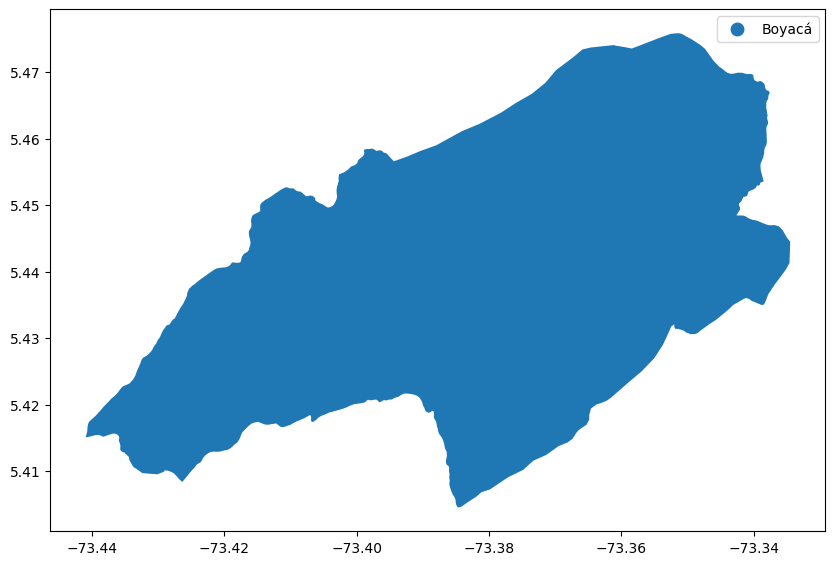

In [ ]:
shape_name = 'Boyacá'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

<a name="sentinel-2"></a>
# Generar imágenes del satélite Sentinel-2
Sentinel-2 es una misión de observación de la Tierra del Programa Copernicus que proporciona imágenes multiespectrales globales cada 10 días (2015 - presente) con una resolución de 10 m (es decir, la longitud de un lado de un píxel es igual a 10 metros).

Las imágenes suelen estar compuestas por 3 canales o bandas: rojo, verde y azul. Sentinel-2, por otro lado, puede capturar 13 bandas espectrales:

4 bandas a 10 metros: azul, verde, rojo e infrarrojo cercano
6 bandas a 20 metros: para caracterización de la vegetación y para aplicaciones como detección de nieve/hielo/nubes o evaluación del estrés hídrico de la vegetación.
3 bandas a 60 metros: principalmente para detección de nubes y correcciones atmosféricas

&nbsp; &nbsp; &nbsp; &nbsp;<img src="https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png" width="400"/>


## Google Earth Engine
En esta sección, demostraremos cómo usar Google Engine para descargar imágenes satelitales de Sentinel-2. Nuevamente, para simplificar, solo descargaremos las bandas RGB de Sentinel-2: rojo (B4), verde (B3) y azul (B2).

En la siguiente celda, definimos una función para generar una imagen de Sentinel-2 desde Google Earth usando la API de Python Earth Engine. Para minimizar la cobertura de nubes, elegimos agregar una colección de imágenes durante un período de tiempo, en lugar de obtener una sola imagen en una fecha determinada.

In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2021-01-01',
    max_date='2024-12-31',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates filtrado de nubes, mediana agregada
    Imagen de Sentinel-2 de Google Earth Engine utilizando la API
    de Python Earth Engine.

    Args:
      region (ee.Geometry): La geometría del área de interés a filtrar.
      product (str): ID activo de Earth Engine
       Puede encontrar la lista completa de ID de ImageCollection
        en https://developers.google.com/earth-engine/datasets
      min_date (str): Fecha mínima para adquirir colección de imágenes satelitales
      max_date (str): Fecha maxima para adquirir colección de imágenes satelitales
      range_min (int): Valor mínimo para el rango de visalización
      range_max (int): Valor maximo para el rango de visalización
      cloud_pct (float): El porcentaje de cobertura de nubes por el que filtrar (predeterminado 10)

    Returns:
      ee.image.Image: Imagen de Sentinel-2 generada recortada en la región de interés
    """

    #Generar compuesto agregado mediano
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Obtener las bandas RGB
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Tenga en cuenta que el valor máximo de las bandas RGB está establecido en 65535
    # porque las bandas de Sentinel-2 son enteros de 16 bits
    # con un rango numérico completo de [0, 65535] (el máximo es 2^16 - 1);
    # Sin embargo, los valores reales son mucho más pequeños que el valor máximo.
    # Fuente: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

Generamos y visualizamos la imagen de satélite Sentinel-2 para Boyaca. La imagen de satélite se genera obteniendo la mediana de todas las imágenes de Sentinel-2 en 2021 con una nubosidad inferior al 10%.

In [ ]:
# Obtenga la geometría de forma para Boyaca
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generacion de imagen RGB usando GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Obtener todas las imagenes entre
    max_date='2021-12-31', # el año 2021
    cloud_pct=10, # Filtrar imágenes con cobertura de nubes >= 10.0%
)

# Visualizar mapa
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

## Guardar imagen en Gdrive
En la siguiente celda, definimos una función para exportar nuestra imagen satelital Sentinel-2 generada a nuestro Google Drive local.

In [ ]:
def export_image(image, filename, region, folder):
    """Exportar imagen a Google Drive.

    Args:
      image (ee.image.Image): Imagen Sentinel-2 generada.
      filename (str): Nombre de la imagen, sin la extensión del archivo.
      geometry (ee.geometry.Geometry): La geometría del área de interés para filtrar.
      folder (str): La carpeta de destino en tu Google Drive.

    Returns:
      ee.batch.Task: Una instancia de la tarea.
    """

    print('Exportando a {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

Ahora podemos proceder a descargar la imagen a nuestro Google Drive local como GeoTIFF.

**Nota**: ¡Ten cuidado al exportar imágenes grandes, ya que pueden tardar un tiempo en descargarse y podrían consumir espacio de almacenamiento!

In [ ]:
folder = 'Colab Notebooks' # cambiar esto por el folder de destino en Google drive
task = export_image(image, 'boyaca', region, folder)

Exporting to boyaca.tif ...


Puede ejecutar task.status() repetidamente para supervisar el estado de la tarea. Después de un tiempo, el estado debería cambiar de "LISTO" a "EN EJECUCIÓN" y luego a "COMPLETO".

También puede ir a https://code.earthengine.google.com/ para verificar el estado de la tarea.

In [ ]:
task.status()

{'state': 'COMPLETED',
 'description': 'boyaca',
 'priority': 100,
 'creation_timestamp_ms': 1733231171283,
 'update_timestamp_ms': 1733231222490,
 'start_timestamp_ms': 1733231184842,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1_4FQ8e6dVnXsQVQt7ml6AZFkYTCmUzCv'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 13.807731628417969,
 'id': 'RECKQO5XPX2RY5Q2CYYQ4TDF',
 'name': 'projects/ee-usos-boyaca/operations/RECKQO5XPX2RY5Q2CYYQ4TDF'}

## Visualizar imagen Sentinel-2A

Una vez que el estado de la tarea cambie a "COMPLETA", verifique que la imagen satelital se encuentre en su Google Drive.

En la siguiente celda, cargamos y visualizamos la imagen satelital rasterizada utilizando la librería Rasterio.

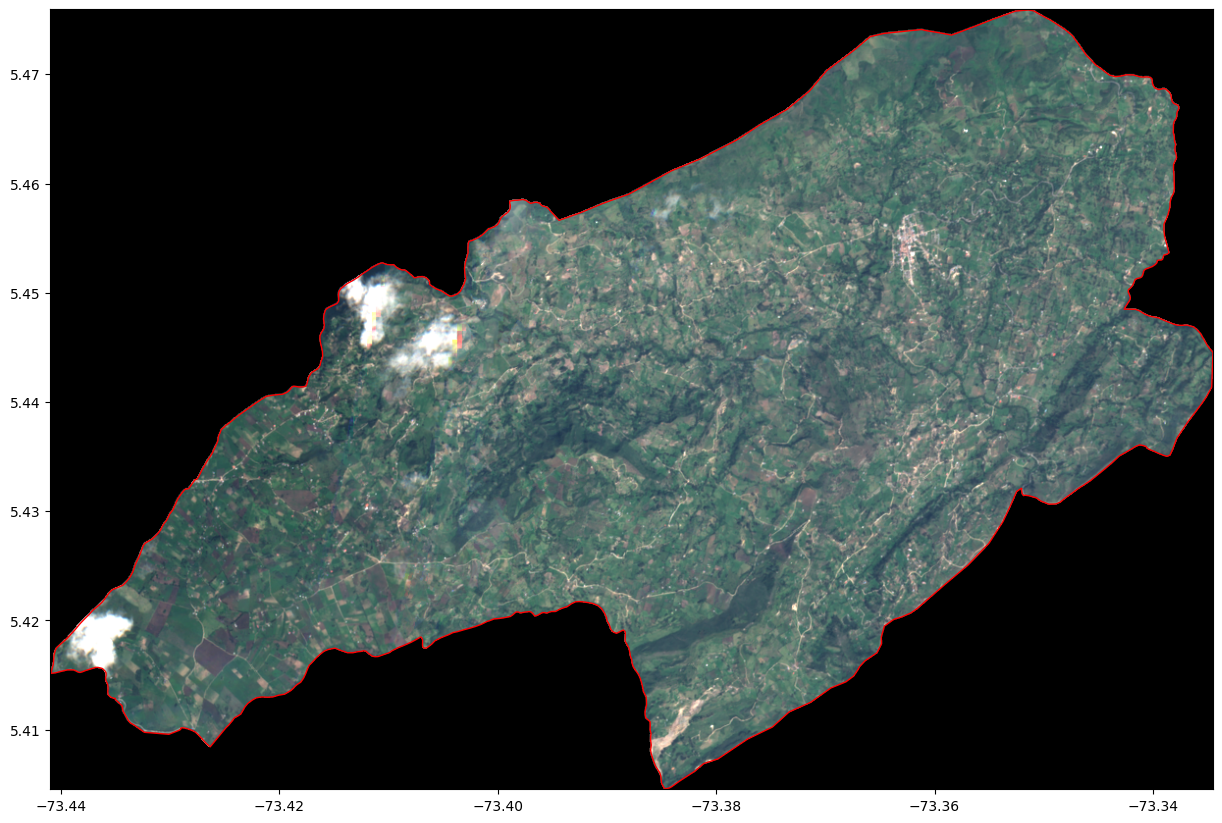

In [ ]:
# Cambia esto a la ruta de tu archivo de imagen
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format('boyaca'))

# Descomenta esto para descargar el archivo TIF
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(shape_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Abre el archivo de imagen usando Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Grafica la imagen y su correspondiente límite
fig, ax = plt.subplots(figsize=(15, 15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="tiles"></a>
# Generar mosaicos GeoJSON de 64 x 64 px

Recuerde que en el tutorial anterior, entrenamos un modelo de aprendizaje profundo en el [conjunto de datos RGB de EuroSAT](), que consta de parches de imagen Sentinel-2 de 64 x 64 píxeles. Esto significa que también necesitaremos dividir nuestra enorme imagen Sentinel-2 en mosaicos más pequeños de 64 x 64 px.

Comencemos por crear una función que genere una cuadrícula de polígonos cuadrados de 64 x 64 px utilizando [Utilidades de ventana de Rasterio](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).

In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Genera teselas poligonales de 64 x 64.

    Args:
      image_file (str): Ruta del archivo de imagen (.tif)
      output_file (str): Ruta del archivo de salida (.geojson)
      area_str (str): Nombre de la región
      size (int): Tamaño de la ventana

    Returns:
      GeoPandas DataFrame: Contiene las teselas poligonales de 64 x 64
    """

    # Abre la imagen ráster usando rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Crea un diccionario que contendrá nuestras teselas poligonales de 64 x 64 px
    # Más tarde convertiremos este diccionario en un DataFrame de GeoPandas.
    geo_dict = {'id': [], 'geometry': []}
    index = 0

    # Realiza un desplazamiento de ventana deslizante sobre la imagen ráster
    with tqdm(total=width * height) as pbar:
        for w in range(0, width, size):
            for h in range(0, height, size):
                # Crea una ventana del tamaño deseado
                window = rio.windows.Window(h, w, size, size)
                # Obtén los límites georreferenciados de la ventana
                bbox = rio.windows.bounds(window, raster.transform)
                # Crea una geometría de shapely a partir del cuadro delimitador
                bbox = box(*bbox)

                # Crea un identificador único para cada geometría
                uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

                # Actualiza el diccionario
                geo_dict['id'].append(uid)
                geo_dict['geometry'].append(bbox)

                index += 1
                pbar.update(size * size)

    # Convierte el diccionario en un DataFrame de GeoPandas
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Establece el CRS a EPSG:4326
    results.crs = {'init': 'epsg:4326'}
    # Guarda el archivo como GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

Ahora podemos crear polígonos cuadrados de tamaño 64x64 px en la imagen satelital Sentinel-2 de Boyaca.

In [ ]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Descomentar para descargar el archivo GeoJSON
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/942075 [00:00<?, ?it/s]

Data dimensions: (247, 2)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id                                           geometry
0  boyacá-0  POLYGON ((-73.43521 5.4702, -73.43521 5.47595,...
1  boyacá-1  POLYGON ((-73.42946 5.4702, -73.42946 5.47595,...
2  boyacá-2  POLYGON ((-73.42371 5.4702, -73.42371 5.47595,...

## Visualizar Mosaicos de 64x64 px

Abramos el archivo ráster Sentinel-2 usando Rasterio y superpongamos los polígonos vectoriales de 64x64px de la siguiente manera.

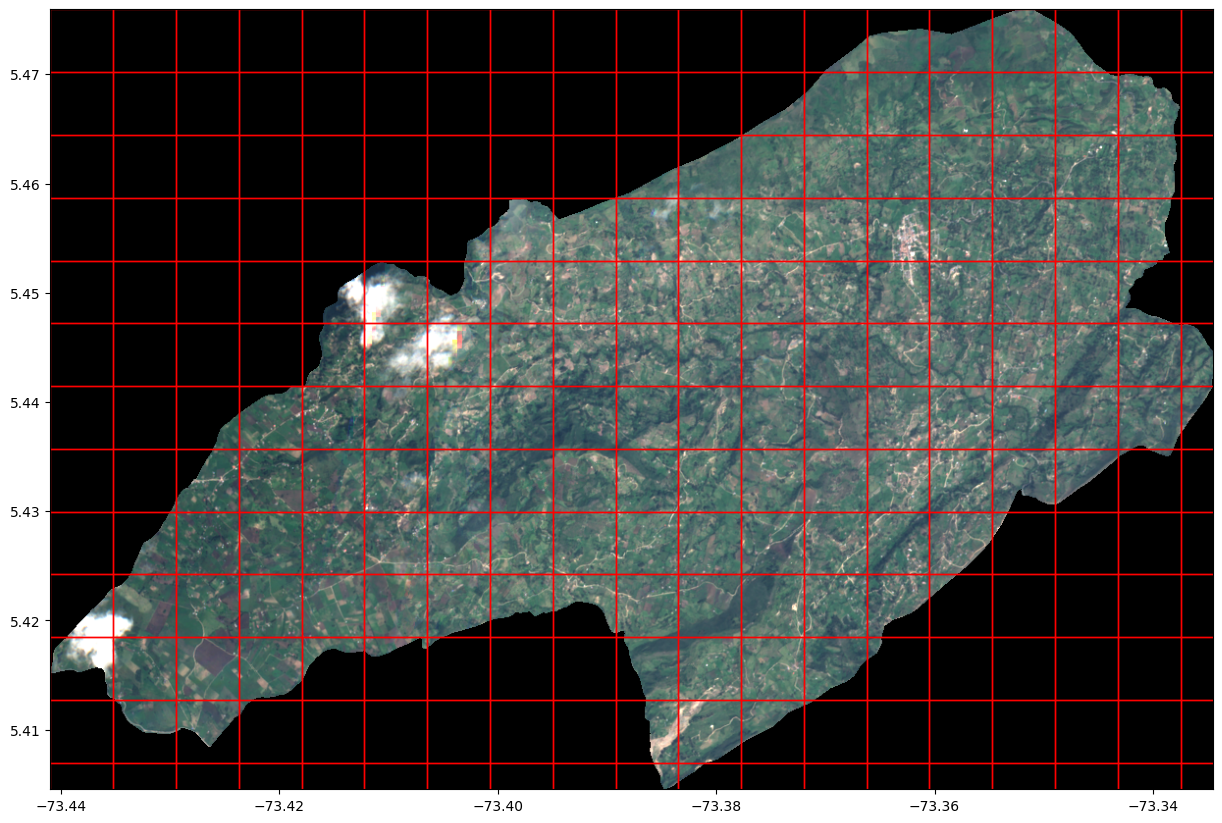

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Observe que los polígonos también se generan para las regiones vacías (negras). Utilizar nuestro modelo para predecir en regiones vacías parece un derroche computacional.

En su lugar, podemos obtener la intersección entre
- el polígono límite de Boyaca y
- las cuadrículas de 64 x 64.

Para ello, utilizamos la función GeoPandas `.sjoin()`. Establecemos el parámetro `predicate='within'` para indicar que sólo queremos los mosaicos que se encuentran dentro de los límites del distrito.

[Más información sobre la función sjoin de GeoPandas aquí](https://geopandas.org/reference/geopandas.sjoin.html).

<ipython-input-72-0e1dd8513c6f>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, predicate='within')


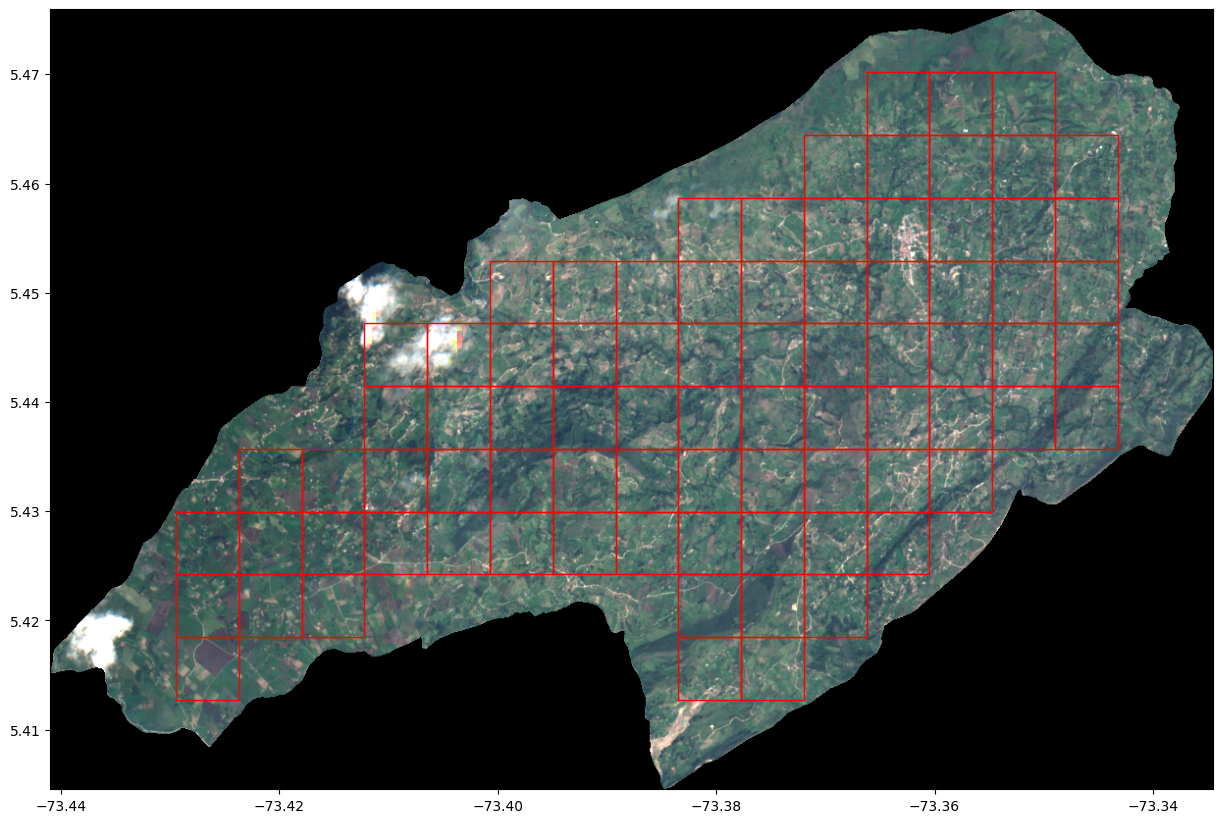

In [ ]:
image = rio.open(tif_file)

# Geopandas funcion sjoin
tiles = gpd.sjoin(tiles, boundary, predicate='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualizar una imagen recortada
Ahora podemos recortar nuestra imagen Sentinel-2 utilizando las rejillas generadas.

Aquí, visualizamos la imagen Sentinel-2 recortada usando el primer mosaico.

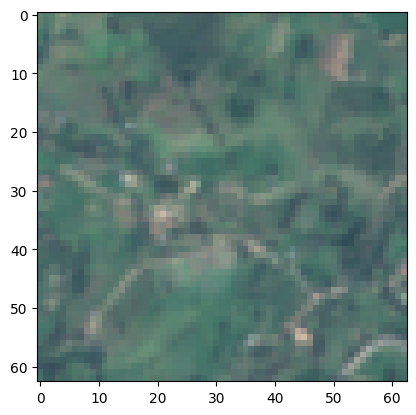

In [ ]:
def show_crop(image, shape, title=''):
  """Recorta una imagen según la forma del polígono..
  Referencia: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Ruta del archivo de imagen (.tif)
    shape (geometry): El mosaico con el que recortar la imagen
    title(str): Titulo de la imagen
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Recortar el borde negro (cero)
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualizar la imagen
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

<a name="lulc-maps"></a>
# Generar el mapa de uso y cobertura del suelo
En esta sección, generaremos nuestro mapa de clasificación de uso y cobertura del suelo utilizando el modelo entrenado en el tutorial anterior. Recordemos que el conjunto de datos EuroSAT consta de 10 clases diferentes de LULC, como se indica a continuación.

In [ ]:
# LULC Clases
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## Cargar el modelo entrenado en EuroSAT
En primer lugar, cargue su modelo entrenado.
Descomentar el código de abajo para descargar directamente el modelo entrenado.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

# Descomentar esto para descargar el modelo entrenado
if not os.path.isfile(model_file):
  model_file = 'best_model.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Downloading...
From (original): https://drive.google.com/uc?id=13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY
From (redirected): https://drive.google.com/uc?id=13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY&confirm=t&uuid=34f8d343-e76d-43f5-8783-c26d9d2df927
To: /content/best_model.pth
100% 94.4M/94.4M [00:04<00:00, 22.5MB/s]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.1MB/s]


Model file best_model.pth successfully loaded.


<ipython-input-75-a450aaa7c421>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


Recuerde que en el tutorial anterior aplicamos un conjunto de transformaciones de datos a nuestro conjunto de prueba. Antes de ejecutar nuestras nuevas imágenes a través del modelo, tendremos que aplicar estas mismas transformaciones a nuestros nuevos datos como sigue.
<center> <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/0*ttoU2HOnBI8cb9Y2.png" width="400"/>
<br>
<font size=2>Fuente de la imagen: <a href="https://pranjal-ostwal.medium.com/data-augmentation-for-computer-vision-b88b818b6010">https://pranjal-ostwal.medium.com/data-augmentation-for-computer-vision-b88b818b6010</a></a> </font>
<br>
</center>
</center>
<br>
<font size=2>Fuente de la imagen: Ahmad, Jamil & Muhammad, Khan & Baik, Sung. (2017). Data augmentation-assisted deep learning of hand-drawn partially colored sketches for visual search. PLOS ONE. 12. e0183838. 10.1371/journal.pone.0183838. </font>
<br>

In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Predicción de modelos y generación de mapas LULC
A continuación, vamos a definir una función que:
1. Recorta la imagen de origen utilizando la geometría de mosaico 64x64
2. Generar una predicción para la imagen recortada utilizando el modelo entrenado.

In [ ]:
def predict_crop(image, shape, classes, model, show=False):
    """Generar la predicción de modelo utilizando el modelo entrenado

    Args:
      image (str): Ruta del archivo de imagen (.tiff)
      shape (geometry): El mosaico con el que recortar la imagene
      classes (list): Lista de clases de LULC

    Return
      str: Etiqueta de clase
    """

    with rio.open(image) as src:
        # Recortar la imagen de origen utilizando la forma poligonal
        # Para mas informacion consultar la documentacion en:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Recortar el borde negro (cero)
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Obtenga los metadatos de la imagen de origen y actualícelos
        # con el ancho, la altura y la transformación de la imagen recortada
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Guardar la imagen recortada como un archivo TIFF temporal.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Abra la imagen recortada y la predicción generada
        # utilizando el modelo de PyTorch entrenado
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

Vamos a iterar sobre cada mosaico de 64x64 px y generar predicciones de modelo para la imagen recortada correspondiente. Debenos tener en cuenta que estamos sobrescribiendo cada archivo TIFF temporal para ahorrar espacio de almacenamiento.

In [ ]:
# Comenzar la predicción del modelo
labels = []
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Guardar Predicciones
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/82 [00:00<?, ?it/s]

id                                           geometry  index_right  \
32  boyacá-32  POLYGON ((-73.36047 5.46445, -73.36047 5.4702,...          229   
33  boyacá-33  POLYGON ((-73.35472 5.46445, -73.35472 5.4702,...          229   
34  boyacá-34  POLYGON ((-73.34897 5.46445, -73.34897 5.4702,...          229   

   shapeName shapeISO                 shapeID shapeGroup shapeType  \
32    Boyacá           7082276B78300809096113        COL      ADM2   
33    Boyacá           7082276B78300809096113        COL      ADM2   
34    Boyacá           7082276B78300809096113        COL      ADM2   

             pred  
32         Forest  
33  PermanentCrop  
34        Pasture

## Visualizar Mapa LULC Interactivo
Por último, mostramos cómo generar un mapa LULC interactivo utilizando Folium.

Empecemos cargando el resultado de las predicciones.

In [ ]:
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))

# Descomente esto para descargar las predicciones del modelo.
if not os.path.isfile(filepath):
  filepath = "{}_preds.geojson".format(shape_name)
  !gdown "1LN4efjd3WPGB1TtNiaHcRbFyBzbFY52A"

tiles = gpd.read_file(filepath)
tiles.head(3)

id  index_right shapeName shapeISO                 shapeID  \
0  boyacá-32          229    Boyacá           7082276B78300809096113   
1  boyacá-33          229    Boyacá           7082276B78300809096113   
2  boyacá-34          229    Boyacá           7082276B78300809096113   

  shapeGroup shapeType           pred  \
0        COL      ADM2         Forest   
1        COL      ADM2  PermanentCrop   
2        COL      ADM2        Pasture   

                                            geometry  
0  POLYGON ((-73.36047 5.46445, -73.36047 5.4702,...  
1  POLYGON ((-73.35472 5.46445, -73.35472 5.4702,...  
2  POLYGON ((-73.34897 5.46445, -73.34897 5.4702,...

A continuación, asignamos a cada etiqueta su color correspondiente.

In [ ]:
# A cada clase del mapa le corresponde un color
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

id  index_right shapeName shapeISO                 shapeID  \
0  boyacá-32          229    Boyacá           7082276B78300809096113   
1  boyacá-33          229    Boyacá           7082276B78300809096113   

  shapeGroup shapeType           pred  \
0        COL      ADM2         Forest   
1        COL      ADM2  PermanentCrop   

                                            geometry    color  
0  POLYGON ((-73.36047 5.46445, -73.36047 5.4702,...  #228b22  
1  POLYGON ((-73.35472 5.46445, -73.35472 5.4702,...  #7fff00

Ten en cuenta que puedes activar o desactivar el mapa con los controles de la parte superior derecha.

In [ ]:
# Centrar el mapa de acuerdo a su centroide
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# A{adir el mapa base satelital de Google
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Añadir el mapa LULC con leyenda
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Especificar el color de la leyenda
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Añadir el GeoJSON al grupo de capas
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

# Conclusión
Al seguir en este tutorial aprendimos a descargar una imagen de satélite Sentinel-2 para la región de Boyacá Google Earth Engine y a aplicar un modelo CNN entrenado para generar un mapa de uso y cobertura del suelo.

## Limitaciones de los datos
Si ha intentado aplicar el modelo a otra región del mundo, descubrirá que el modelo no funciona tan bien en determinadas zonas. A continuación señalamos algunas de las limitaciones del conjunto de datos EuroSAT:
- Las 10 clases de cobertura del suelo del conjunto de datos EuroSAT no son representativas del complejo contenido de los datos de teledetección. Estas etiquetas de clase no son mutuamente disjuntas (por ejemplo, una imagen puede contener tanto una autopista como una zona residencial) y su unión no cubre la distribución en el mundo real (por ejemplo, ciertos tipos de cobertura del suelo como las tierras desérticas y la acuicultura no están presentes en el conjunto de datos).
- Al igual que muchos conjuntos de datos de teledetección existentes, EuroSAT, que consiste en imágenes de satélite distribuidas por toda Europa, tiene una cobertura geográfica limitada que restringe la generalizabilidad del modelo a otras regiones del mundo. Por lo tanto, para mejorar la cobertura global de los conjuntos de datos de teledetección anotados es necesaria la colaboración con diversas instituciones de investigación y una mayor puesta en común de los datos.

# Bibliografia
- Coordinate Reference Systems – Introduction to Geospatial Concepts. (n.d.). Data Carpentry - Introduction to Geospatial Concepts. Retrieved February 14, 2021, from https://datacarpentry.org/organization-geospatial/03-crs/
- USGS EROS Archive - Sentinel-2. (n.d.). USGS. Retrieved February 14, 2021, from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
- Long, Yang, Gui-Song Xia, Shengyang Li, Wen Yang, Michael Ying Yang, Xiao Xiang Zhu, Liangpei Zhang, and Deren Li. “DIRS: On creating benchmark datasets for remote sensing image interpretation.” arXiv preprint arXiv:2006.12485 (2020). https://arxiv.org/pdf/1912.12171.pdf
- Zhu, Xiao Xiang, et al. “So2Sat LCZ42: A benchmark dataset for global local climate zones classification.” arXiv preprint arXiv:1912.12171 (2019). https://arxiv.org/pdf/1912.12171.pdf
- Sumbul, Gencer, et al. "Bigearthnet: A large-scale benchmark archive for remote sensing image understanding." IGARSS 2019-2019 IEEE International Geoscience and Remote Sensing Symposium. IEEE, 2019.
- Lai, Li, et al. "Carbon emissions from land-use change and management in China between 1990 and 2010." Science Advances 2.11 (2016): e1601063.